In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

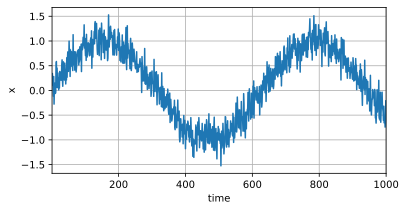

In [3]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time=torch.arange(1, T+1, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time)+torch.randn(T)*0.2
        
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1,1000], figsize=(6,3))

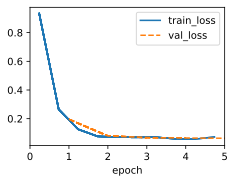

In [4]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features=[self.x[i:self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features,1)
    self.labels=self.x[self.tau:].reshape((-1,1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

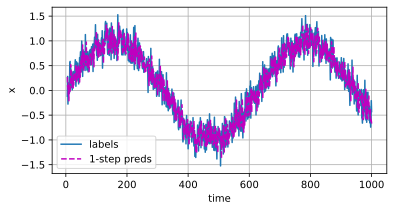

In [5]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x', 
         legend=['labels', '1-step preds'], figsize=(6, 3))

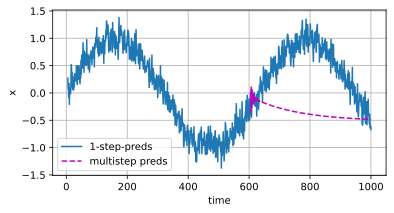

In [6]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i-data.tau:i].reshape((1,-1))
    )
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time', 'x',
         legend=['1-step-preds', 'multistep preds'], figsize= (6,3))

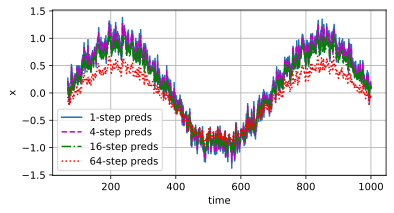

In [7]:
def k_step_pred(k):
    features=[]
    for i in range(data.tau):
        features.append(data.x[i:i+data.T-data.tau-k+1])
    for i in range(k):
        preds=model(torch.stack(features[i:i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k-1].detach().numpy() for k in steps], 'time', 'x',
          legend=[f'{k}-step preds' for k in steps], figsize=(6,3))

In [8]:
import collections 
import random 
import re 
import torch 
from d2l import torch as d2l

In [9]:
class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset.""" 
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root, '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
data = TimeMachine() 
raw_text = data._download() 
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [10]:
@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()
text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

In [11]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [12]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        self.idx_to_token = list(sorted(set(['<unk>']+ reserved_tokens +
                                          [token for token, freq in self.token_freqs if freq>=min_freq])))
        self.token_to_idx = {token:idx for idx, token in enumerate(self.idx_to_token)}
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) >1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    
    @property
    def unk(self):
        return self.token_to_idx['<unk>']

vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [13]:
@d2l.add_to_class(TimeMachine)
def build(self, raw_text, vocab = None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab
corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [14]:
words = text.split() 
vocab = Vocab(words) 
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

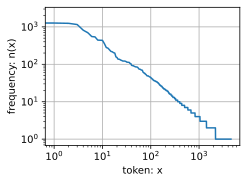

In [15]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel = 'frequency: n(x)', xscale = 'log', yscale = 'log')

In [16]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [17]:
trigram_tokens = ['--'.join(triple) for triple in zip( 
                words[:-2], words[1:-1], words[2:])] 
trigram_vocab = Vocab(trigram_tokens) 
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

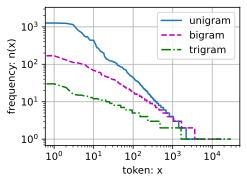

In [18]:
bigram = [freq for token, freq in bigram_vocab.token_freqs]
trigram = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram, trigram], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend = ['unigram', 'bigram', 'trigram'])

In [19]:
import torch 
from d2l import torch as d2l

In [20]:
@d2l.add_to_class(d2l.TimeMachine)
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

@d2l.add_to_class(d2l.TimeMachine)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train+self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

data = d2l.TimeMachine(batch_size=2, num_steps=10) 
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y) 
    break

X: tensor([[ 6,  5,  0,  7, 19, 16, 14,  0, 26, 16],
        [ 5, 10, 14,  6, 15, 20, 10, 16, 15,  0]]) 
Y: tensor([[ 5,  0,  7, 19, 16, 14,  0, 26, 16, 22],
        [10, 14,  6, 15, 20, 10, 16, 15,  0, 16]])


In [21]:
X, W_xh = torch.randn(3,1), torch.randn(1, 4)
H, W_hh = torch.randn(3,4), torch.randn(4,4)
torch.matmul(X, W_xh) + torch.matmul(H,W_hh)

tensor([[-1.1630, -1.6641, -1.7516,  2.0415],
        [ 0.1425, -3.3839,  0.4423, -0.2540],
        [ 0.6921, -2.6962, -0.7285, -1.9593]])

In [22]:
torch.matmul(torch.cat((X,H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-1.1630, -1.6641, -1.7516,  2.0415],
        [ 0.1425, -3.3839,  0.4423, -0.2540],
        [ 0.6921, -2.6962, -0.7285, -1.9593]])

In [1]:
%matplotlib inline 
import math 
import torch 
from torch import nn 
from torch.nn import functional as F 
from d2l import torch as d2l

In [11]:
class RNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens)*sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens)*sigma)
        self.b_h=nn.Parameter(torch.zeros(num_hiddens))

In [12]:
@d2l.add_to_class(RNNScratch)
def forward(self, inputs, state=None):
    if state is None:
        state = torch.zeros((inputs.shape[1], self.num_hiddens), 
                            device = inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:
        state = torch.tanh(torch.matmul(X, self.W_xh)+
                           torch.matmul(state, self.W_hh)+self.b_h)
        outputs.append(state)
    return outputs, state

In [13]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [17]:
def check_len(a, n):
    assert len(a) ==n, f'list\'s length {len(a)} != expected length {n}'
    
def check_shape(a, shape):
    assert a.shape == shape, \
        f'tensor\'s shape {a.shape} != expected shape {shape}'
        
check_len(outputs, num_steps) 
check_shape(outputs[0], (batch_size, num_hiddens)) 
check_shape(state, (batch_size, num_hiddens))